In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from dotenv import load_dotenv, find_dotenv
import os
from datetime import date, timedelta

pd.set_option('display.max_columns', None)

In [2]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")


In [3]:
columns_to_keep_games_stats = ["PlayerId", "CreatedAt", "UpdatedAt", "Map",  "Kills", "Deaths", "Assists", "Headshots", "FirstHalfScore", "SecondHalfScore",'QuadroKills', 'TripleKills', 'PentaKills',"Headshots", "Headshots%","K/rRatio", "K/dRatio", 'Mvps', "OvertimeScore", "Rounds", "Score", "Result"]


In [4]:
def rename_cols(text: str):
    text = text.split(".")[1]
    text = text.split(" ")
    text = "".join(list(map(str.capitalize, text)))
    return text



def read_json():
    with open(f"../data/raw/Game Stats/{FACEIT_PLAYERID}_games_stats.json", "r") as file:
        obj = json.load(file)
    df = pd.json_normalize(obj)
    df = df.rename(columns=rename_cols)
    return df

In [5]:
df = read_json()[columns_to_keep_games_stats]

In [6]:
df['DateOrdinal'] = pd.to_datetime(df['CreatedAt']).apply(lambda date: date.toordinal())


In [7]:
type_casting = {"PlayerId": str, "CreatedAt": "datetime64[ns]", "UpdatedAt":  "datetime64[ns]", "Kills": int, "Deaths": int, "Assists": int, "Headshots": int, "FirstHalfScore":int, "SecondHalfScore": int, "QuadroKills": int,  "TripleKills": int, "PentaKills": int, "Mvps": int, "OvertimeScore": int, "Rounds": int, "Result": int}
df = df.astype(type_casting, errors = "ignore")
df.dropna(how = "any", inplace=True)
df["Result"] = df["Result"].astype(int).astype(bool)

In [8]:
def set_date_labels(ax):
    new_labels = [date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()]
    ax.set_xlabel(new_labels)
    return ax

In [9]:
deltas = df['CreatedAt'][::-1].diff()[1:]
streaks = deltas[deltas < timedelta(days=1)]


In [10]:
cols  = ['Kills', 'Deaths', 'Assists', 'Headshots', 'FirstHalfScore',
       'SecondHalfScore', 'QuadroKills', 'TripleKills', 'PentaKills',
       'Mvps', 'OvertimeScore', 'Rounds']

overall_cols = ['Kills', 'Deaths', 'Assists', 'Headshots', 'Mvps']

In [11]:
df["Year"] = df["CreatedAt"].dt.year
df["Month"] = df["CreatedAt"].dt.month
df["Day"] = df["CreatedAt"].dt.day

C:\Users\local_ec22805\Temp\ipykernel_20308\2676288042.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation = 30)


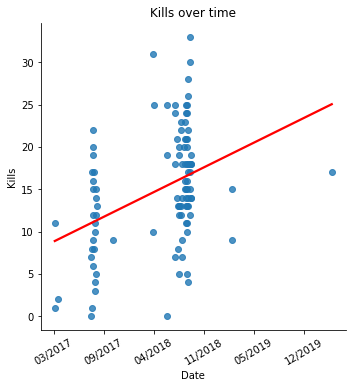

In [12]:
g = sns.lmplot(data= df, x = "DateOrdinal", y = "Kills", ci=None, line_kws={"color" : "red"}, facet_kws=dict(sharex=False, sharey=False))
#plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels, rotation = 30)
    ax.set_xlabel("Date")
    ax.set_title("Kills over time")
    
plt.show()




C:\Users\local_ec22805\Temp\ipykernel_20308\1959390525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation = 30, ha='center')
C:\Users\local_ec22805\Temp\ipykernel_20308\1959390525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation = 30, ha='center')
C:\Users\local_ec22805\Temp\ipykernel_20308\1959390525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation = 30, ha='center')
C:\Users\local_ec22805\Temp\ipykernel_20308\1959390525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation = 30, ha='center')


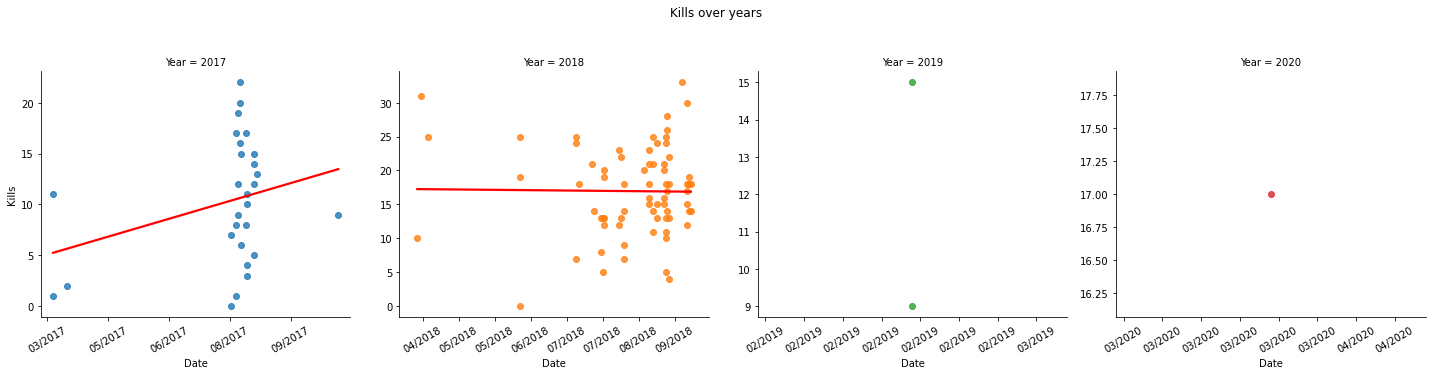

In [13]:
g = sns.lmplot(data= df, x = "DateOrdinal", y = "Kills", col = "Year", hue = "Year", x_jitter=False, ci=None, line_kws={"color" : "red"}, facet_kws=dict(sharex=False, sharey=False))
g.set_titles("{col_name}")
for ax in g.axes.flat:
    year = int(ax.get_title())
    mini, maxi = df.query("Year == @year")["DateOrdinal"].agg([min, max]).values
    ax.set_xlim(left=mini-10, right = maxi+10)
    new_labels = []
    for item in ax.get_xticks():
        new_labels.append(date.fromordinal(int(item)).strftime("%m/%Y") )
    ax
    ax.set_xticklabels(new_labels, rotation = 30, ha='center')
    ax.set_xlabel("Date")
g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
g.fig.suptitle("Kills over years")
g.set_titles("Year = {col_name}")
plt.show()




As we can see, the last game was played there are 2 massive clusters of data with visible outliers. I want only 

1) Data is centred around 2 values -> the most active
2) Outliers present, need to delete



In [14]:
df.head()

,PlayerId,CreatedAt,UpdatedAt,Map,Kills,Deaths,Assists,Headshots,FirstHalfScore,SecondHalfScore,QuadroKills,TripleKills,PentaKills,Headshots,Headshots%,K/rRatio,K/dRatio,Mvps,OvertimeScore,Rounds,Score,Result,DateOrdinal,Year,Month,Day
0,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2020-03-28 23:24:01.382,2020-03-28 23:25:40.927,de_dust2,17,16,3,8,6,3,0,1,0,8,47,0.68,1.06,2,0,25,16 / 9,False,737512,2020,3,28
1,2fb9fe10-5c7e-4f2f-860b-sa9ee2f88801a,2019-02-22 01:46:04.960,2019-02-22 01:47:34.311,de_train,9,21,0,7,3,5,0,0,0,7,78,0.38,0.43,0,0,24,16 / 8,False,737112,2019,2,22
2,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2019-02-22 00:47:37.372,2019-02-22 00:49:08.208,de_mirage,15,18,0,8,4,3,1,0,0,8,53,0.65,0.83,1,0,23,16 / 7,False,737112,2019,2,22
3,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2018-09-12 08:15:31.590,2018-09-12 08:16:57.279,de_cache,18,19,3,11,7,9,0,3,0,11,61,0.62,0.95,5,0,29,13 / 16,True,736949,2018,9,12
4,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2018-09-12 07:14:34.446,2018-09-12 07:15:45.275,de_mirage,14,10,2,9,13,3,0,0,0,9,64,0.67,1.4,1,0,21,16 / 5,True,736949,2018,9,12


In [15]:
df.select_dtypes(include=np.number).columns.tolist()
Maps = df.groupby(by = "Map").aggregate({'Kills': sum, 'Deaths': sum,  "Mvps": sum, "Map": "count", "Result": sum}).rename({"Map": "TimesPlayed"}, axis = 1)


In [16]:
Maps.sort_values(by = "TimesPlayed", inplace=True, ascending=False)
Maps["K/D"] = round(Maps["Kills"]/Maps["Deaths"], 2)

In [17]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} games)".format(pct, absolute)

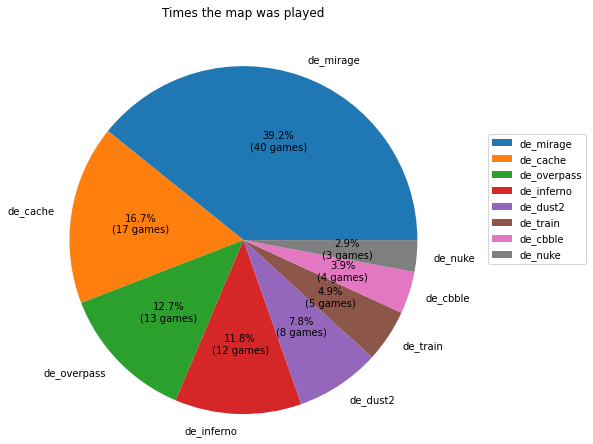

In [18]:
fig, ax = plt.subplots()
p, tx, autotexts = ax.pie(Maps["TimesPlayed"], labels = Maps.index, autopct = lambda pct: func(pct, Maps["TimesPlayed"]), radius = 2, )
ax.xaxis.set_label_position('top')
ax.set_title('Times the map was played', y=1.5)

plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()

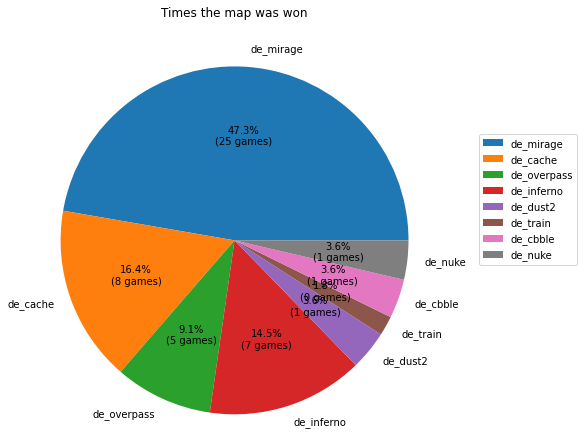

In [19]:
fig, ax = plt.subplots()
ax.pie(Maps["Result"], labels = Maps.index, autopct = lambda pct: func(pct, Maps["Result"]), radius = 2, )
ax.xaxis.set_label_position('top')
ax.set_title('Times the map was won', y=1.5)
plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()

TypeError: boxplot() got an unexpected keyword argument 'gap'

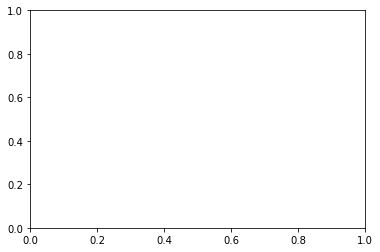

In [30]:
sns.boxplot(data = df, x ="Map", y = "Kills", hue = "Result", gap = .1)